### Gradient Descent

&nbsp;

Gradient descent is machine learning 101. Gradient refers to the derivative of a matrix in linear algebra. The basics of GD is similar to Ordinary Least Square. They are using the same approach to minimize the mean square error. The only difference is that OLS gets the global optima via inverse while GD gets the local optima via iteration. Theoretically, the computation of inverse matrix would be more costly than the convergence of iteration in a really large matrix. 

Assuming we have an equation $y=x\theta+\epsilon$, where $y,\epsilon \in \mathbb{R}^m$, $x \in \mathbb{R}^{m \times n}$ and $\theta \in \mathbb{R}^{n}$.

* OLS solves the problem by minimizing $J(\theta)=(y-x\theta)^T(y-x\theta)$ with respect to $\theta$. By setting the partial derivative $\frac{\partial J(\theta)}{\partial \theta}=0$, we shall obtain $\theta=(x^Tx)^{-1}x^Ty$. 

* GD solves the problem by iterations of $\theta:=\theta-\alpha\frac{\partial J(\theta)}{\partial \theta}$, where $\alpha$ denotes the learning rate and $\frac{\partial J(\theta)}{\partial \theta}=x^T(x\theta-y)$.

So when do we stop the iteration of GD? This is where data science becomes state of art. This is no definite way. We have to preset the threshold $\tau$, and when the threshold $\tau$ is beached, we declare the algorithm has converged. The threshold $\tau$ could be the percentage/absolute change of the coefficients or objective functions or sum of squared errors from the last iteration. The optimal $\tau$ should be small enough so we get a more accurate result but not too small to drag down the performance. And hyperparameter $\alpha$ is also crucial to the success of the algorithm. If $\alpha$ is too large, we would oscillate around the optima without convergence. On the contrary, a really small $\alpha$ takes forever to reach the optima.

The application of GD ranges from Independent Component Analysis to Neural Networks. As long as we can solve the objective function in closed form (otherwise we need Expectation Maximization), we can always apply GD instead of OLS or Maximum Logarithm Likelihood to outperform the computation of the inverse matrix. 

Another material for your reference

http://ozzieliu.com/2016/02/09/gradient-descent-tutorial/

Reference to the application of GD in ICA

https://github.com/je-suis-tm/machine-learning/blob/master/independent%20component%20analysis.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.decomposition
import sklearn.datasets
from mpl_toolkits.mplot3d import Axes3D

### Batch Gradient Descent

&nbsp;

Batch Gradient Descent is the simplest form of GD. BGD takes consideration of the error from the entire dataset at each iteration.

In [2]:
#simple ols in linear regression
def ols(X,Y):
    return np.linalg.inv(X.T@X)@X.T@Y

In [3]:
#batch gradient descent
#alpha denotes learning rate 
#alpha usually takes 0.05,0.03,0.01,0.005,0.003,0.001 etc
#tau denotes the threshold of convergence
#tau usually take 0.01,0.001,0.0001,0.00001
#we should try different hyper parameters
#we need to balance the tradeoff between precision and performance
def bgd(X,Y,tau=0.001,alpha=0.001,max_itr=1000,
        theta_init=[],diagnosis=True):

    #initialize
    counter=0

    #theta denotes coefficients
    #initialize theta
    if len(theta_init)>0:
        theta=theta_init
    else:
        theta=np.ones((X.shape[1],1))

    #residuals or you can call it objective function
    epsilons=[]
    
    #collect thetas for viz
    thetas=[theta.copy()]

    #iterate through the entire dataset
    while counter<max_itr:
        x=X.copy()
        y=Y.copy()

        #gradient descent
        y_estimated=x@theta
        epsilon=y_estimated-y
        gradient=x.T@epsilon
        theta-=alpha*gradient

        #tracking
        counter+=1
        epsilons.append(epsilon.ravel()[0])
        thetas.append(theta.copy())

        #convergence
        if len(epsilons)>1 and abs(epsilons[-1]-epsilons[-2])<tau:
            if diagnosis:
                print(f'Converged after {counter} iterations.')
            return thetas,epsilons
                
    if diagnosis:
        print(f'Not converged.')
    return thetas,epsilons

In [4]:
#iris dataset is the default choice in this repository
#plz refer to the website in the following link for original data
# https://archive.ics.uci.edu/ml/datasets/iris
iris=sklearn.datasets.load_iris()

In [5]:
#to make life easier
#we start with a binary classification problem
dataset=iris.data[iris.target!=2]
Y=iris.target[iris.target!=2]

In [6]:
#use principal component analysis to reduce dimensions for viz
#check link below for details on pca
# https://github.com/je-suis-tm/machine-learning/blob/master/principal%20component%20analysis.ipynb
X=sklearn.decomposition.PCA(n_components=2).fit_transform(dataset)

In [7]:
#make sure its in the vector form
Y=Y.reshape(-1,1)

#adding intercept
#you can also do 
#import statsmodels.api as sm
#X=sm.add_constant(X
constant=np.ones((X.shape[0],1))
X=np.concatenate([constant,X],axis=1)

In [8]:
#run
thetas_bgd,_=bgd(X,Y)
theta_ols=ols(X,Y)
theta_bgd=thetas_bgd[-1]

Converged after 76 iterations.


In [9]:
#apparently ols is much faster
%timeit bgd(X,Y,diagnosis=False)

1.69 ms ± 14.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%timeit ols(X,Y)

32.7 µs ± 517 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
print('Coefficients from BGD\n',theta_bgd)
print('Coefficients from OLS\n',theta_ols)

Coefficients from BGD
 [[0.50016649]
 [0.29194508]
 [0.03695356]]
Coefficients from OLS
 [[ 0.5       ]
 [ 0.29194508]
 [-0.1693774 ]]


In [12]:
#compute sum of squared errors
sse_bgd=((X@theta_bgd-Y).T@(X@theta_bgd-Y)).ravel()[0]
sse_ols=((X@theta_ols-Y).T@(X@theta_ols-Y)).ravel()[0]

#ols also has smaller variance
print('Sum of squared errors from BGD\n',sse_bgd)
print('Sum of squared errors from OLS\n',sse_ols)

Sum of squared errors from BGD
 1.9240423019186674
Sum of squared errors from OLS
 0.9633040783278697


In [13]:
#get forecast
forecast_bgd=np.sign(X@theta_bgd)
forecast_bgd[forecast_bgd<0]=0
forecast_ols=np.array([abs(round(i[0],0)) for i in X@theta_ols])

#bgd is less accurate as well
print('Accuracy of BGD\n',len(forecast_bgd[forecast_bgd==Y])/len(Y))
print('Accuracy of OLS\n',len(forecast_ols[forecast_ols==Y.ravel()])/len(Y))

Accuracy of BGD
 0.64
Accuracy of OLS
 1.0


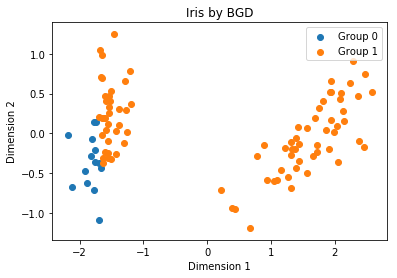

In [14]:
plt.title('Iris by BGD')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
for i in np.unique(forecast_bgd.ravel()):
    plt.scatter(X[forecast_bgd.ravel()==i][:,1],
                X[forecast_bgd.ravel()==i][:,2],
                label=f'Group {int(i)}')
plt.legend()
plt.show()


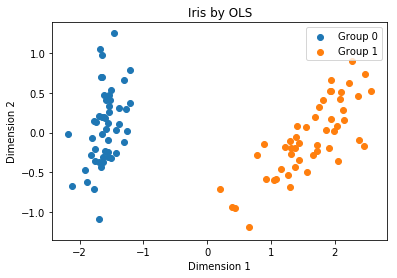

In [15]:
plt.title('Iris by OLS')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
for i in np.unique(forecast_ols):
    plt.scatter(X[forecast_ols==i][:,1],
                X[forecast_ols==i][:,2],
                label=f'Group {int(i)}')
plt.legend()
plt.show()

### Stochastic Gradient Descent

&nbsp;

Stochastic Gradient Descent is designed to boost the performance of GD. SGD takes consideration of the error from a random sample at each iteration which greatly reduces the computation burden.

In [16]:
#sklearn official sgd
def skl_sgd(X,Y,**kwargs):

    #keep the hyper parameters consistent with self implementation
    clf=sklearn.linear_model.SGDClassifier(loss='squared_loss',
                                           fit_intercept=False,
                                           alpha=0.001,l1_ratio=0,
                                           max_iter=1000,tol=0.001,
                                           **kwargs)
    clf.fit(X,Y)
    
    print(f'Sklearn converged after {clf.n_iter_} iterations')
    print('Accuracy of Sklearn\n',clf.score(X,Y))

    return clf.coef_.T

In [17]:
#stochastic gradient descent
#the only difference from bgd is the bootstrapping
#bgd iterates through the entire dataset at each step
#sgd randomly picks a set of data and runs gradient descent
#until it reaches convergence or maximum number of iterations
def sgd(X,Y,tau=0.001,alpha=0.001,max_itr=1000,
        theta_init=[],diagnosis=True):

    #initialize
    counter=0

    #theta denotes coefficients
    #initialize theta
    if len(theta_init)>0:
        theta=theta_init
    else:
        theta=np.ones((X.shape[1],1))

    #residuals or you can call it objective function
    epsilons=[]
    
    #collect thetas for viz
    thetas=[theta.copy()]

    #iterate through the dataset
    while counter<max_itr:
        
        #bootstrapping
        i=np.random.randint(X.shape[0])        
        x=X[i].reshape(1,-1)
        y=Y[i].reshape(-1,1)

        #gradient descent
        y_estimated=x@theta
        epsilon=y_estimated-y
        gradient=x.T@epsilon
        theta-=alpha*gradient

        #tracking
        counter+=1
        epsilons.append(epsilon.ravel()[0])
        thetas.append(theta.copy())

        #convergence
        if len(epsilons)>1 and abs(epsilons[-1]-epsilons[-2])<tau:
            if diagnosis:
                print(f'SGD has converged after {counter} iterations.')
            return thetas,epsilons
                
    if diagnosis:
        print(f'SGD has not converged.')
    return thetas,epsilons

In [18]:
#well sgd result is quite volatile due to its randomness
thetas_sgd,_=sgd(X,Y)
theta_sgd=thetas_sgd[-1]

forecast_sgd=np.sign(X@theta_sgd)
forecast_sgd[forecast_sgd<0]=0
print('Accuracy of SGD\n',len(forecast_sgd[forecast_sgd==Y])/len(Y))

SGD has converged after 39 iterations.
Accuracy of SGD
 0.89


In [19]:
#i have no idea why sklearn is so damn accurate
theta_skl=skl_sgd(X,Y)

Sklearn converged after 52 iterations
Accuracy of Sklearn
 1.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [20]:
print('Coefficients from SGD\n',theta_sgd)
print('Coefficients from Sklearn\n',theta_skl)

Coefficients from SGD
 [[0.97243862]
 [0.92915242]
 [0.9915781 ]]
Coefficients from Sklearn
 [[ 0.14486601]
 [ 0.58746859]
 [-0.39961859]]


In [21]:
#compute sum of squared errors
sse_sgd=((X@theta_sgd-Y).T@(X@theta_sgd-Y)).ravel()[0]
sse_skl=((X@theta_skl-Y).T@(X@theta_skl-Y)).ravel()[0]

#sklearn also has smaller variance
print('Sum of squared errors from SGD\n',sse_sgd)
print('Sum of squared errors from Sklearn\n',sse_skl)

Sum of squared errors from SGD
 165.12271031840393
Sum of squared errors from Sklearn
 38.73778731948959


In [22]:
#in our case, sgd doesnt seem to be efficient
%timeit sgd(X,Y,diagnosis=False)

8.52 ms ± 561 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


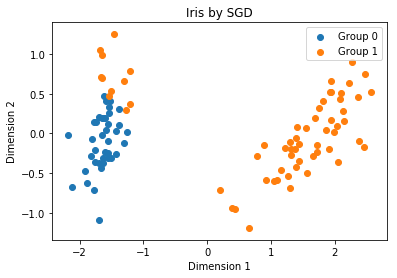

In [23]:
plt.title('Iris by SGD')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
for i in np.unique(forecast_sgd.ravel()):
    plt.scatter(X[forecast_sgd.ravel()==i][:,1],
                X[forecast_sgd.ravel()==i][:,2],
                label=f'Group {int(i)}')
plt.legend()
plt.show()


### Mini-batch Gradient Descent

&nbsp;

Mini-batch Gradient Descent is a mixture of BGD and SGD. MBGD takes consideration of the error from a subset at each iteration. It attempts to balance the tradeoff between efficiency from SGD and effectiveness from BGD. However, it creates a new hyperparameter for us to tune, batch size. Our learning rate $\alpha$ is required to adapt with the change of batch size. 

More details of batch size can be found in the discussion below.

https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu

In [24]:
#mini batch gradient descent
#a mixture of sgd and bgd
def mbgd(X,Y,tau=0.001,alpha=0.001,max_itr=1000,
        theta_init=[],batch_size=32,shuffle=False,
         diagnosis=True):

    #initialize
    counter=0

    #theta denotes coefficients
    #initialize theta
    if len(theta_init)>0:
        theta=theta_init
    else:
        theta=np.ones((X.shape[1],1))

    #residuals or you can call it objective function
    epsilons=[]
    
    #collect thetas for viz
    thetas=[theta.copy()]
    
    #shuffled subset
    aleatoire=np.random.choice(X.shape[0],batch_size)

    #iterate through the entire dataset
    while counter<max_itr:
        
        #shuffled subset
        if shuffle:
            aleatoire=np.random.choice(X.shape[0],batch_size)
        x=X[aleatoire]
        y=Y[aleatoire]            

        #gradient descent
        y_estimated=x@theta
        epsilon=y_estimated-y
        gradient=x.T@epsilon/x.shape[0]
        theta-=alpha*gradient

        #tracking
        counter+=1
        epsilons.append(epsilon.ravel()[0])
        thetas.append(theta.copy())

        #convergence
        if len(epsilons)>1 and abs(epsilons[-1]-epsilons[-2])<tau:
            if diagnosis:
                print(f'Converged after {counter} iterations.')
            return thetas,epsilons
                
    if diagnosis:
        print(f'Not converged.')
    return thetas,epsilons

In [25]:
#well mbgd is supposed to be between bgd and sgd
thetas_mbgd,_=mbgd(X,Y,shuffle=False)
theta_mbgd=thetas_mbgd[-1]

Converged after 331 iterations.


In [26]:
#mbgd is not that accurate
forecast_mbgd=np.sign(X@theta_mbgd)
forecast_mbgd[forecast_mbgd<0]=0
print('Accuracy of MBGD\n',len(forecast_mbgd[forecast_mbgd==Y])/len(Y))

Accuracy of MBGD
 0.77


In [27]:
print('Coefficients from MBGD\n',theta_mbgd)

Coefficients from MBGD
 [[0.90860075]
 [0.65742179]
 [0.94107646]]


In [28]:
#as expected, its sse is somewhere between bgd and sgd
sse_mbgd=((X@theta_mbgd-Y).T@(X@theta_mbgd-Y)).ravel()[0]
print('Sum of squared errors from MBGD\n',sse_mbgd)

Sum of squared errors from MBGD
 82.1414376313023


In [29]:
#apparently mbgd is not that better than bgd in performance
%timeit mbgd(X,Y,shuffle=False,diagnosis=False)

12.4 ms ± 500 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
#with shuffled subset at each iteration
#the performance is even slower
%timeit mbgd(X,Y,shuffle=True,diagnosis=False)

28.3 ms ± 4.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


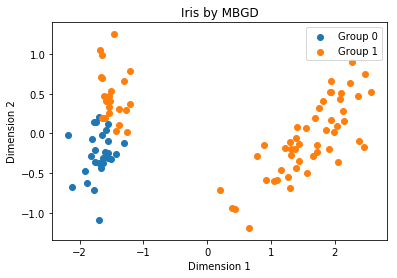

In [31]:
plt.title('Iris by MBGD')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
for i in np.unique(forecast_mbgd.ravel()):
    plt.scatter(X[forecast_mbgd.ravel()==i][:,1],
                X[forecast_mbgd.ravel()==i][:,2],
                label=f'Group {int(i)}')
plt.legend()
plt.show()


### Convergence Comparison

In [32]:
#get sum of squared errors
epsilons_bgd=[((X@i-Y).T@(X@i-Y).ravel())[0] for i in thetas_bgd]
epsilons_sgd=[((X@i-Y).T@(X@i-Y).ravel())[0] for i in thetas_sgd]
epsilons_mbgd=[((X@i-Y).T@(X@i-Y).ravel())[0] for i in thetas_mbgd]

In [33]:
#create x and y coordinates
shape_x=np.linspace(theta_ols.ravel()[1]-1,theta_ols.ravel()[1]+1,11)
shape_y=np.linspace(theta_ols.ravel()[2]-1,theta_ols.ravel()[1]+1,11)
hyperplane_x,hyperplane_y=np.meshgrid(shape_x,shape_y)

#create z coordinates based upon sum of squared errors
shape_z=[]
for i in zip(np.ravel(hyperplane_x), np.ravel(hyperplane_y)):
    theta=np.hstack((theta_ols[0],np.array(i))).reshape(-1,1)
    shape_z.append(((X@theta-Y).T@(X@theta-Y)).ravel()[0])
hyperplane_z=np.array(shape_z).reshape(hyperplane_x.shape)

In [34]:
%matplotlib notebook

<IPython.core.display.Javascript object>


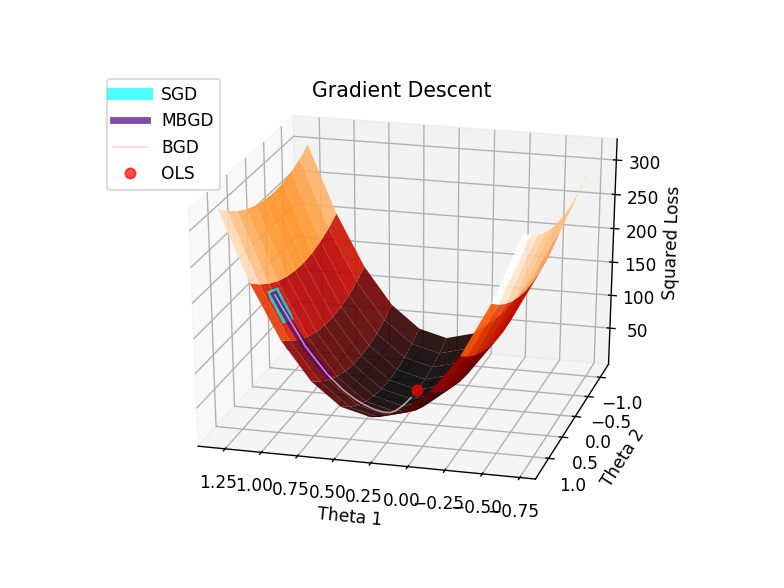

In [35]:
#viz
ax=plt.figure(dpi=70).add_subplot(111, projection='3d')

ax.plot([i[1] for i in thetas_sgd],
        [i[2] for i in thetas_sgd],
        epsilons_sgd,label='SGD',
        alpha=0.7,color='cyan',lw=7)
ax.plot([i[1] for i in thetas_mbgd],
        [i[2] for i in thetas_mbgd],
        epsilons_mbgd,label='MBGD',
        alpha=0.7,color='indigo',lw=4)
ax.plot([i[1] for i in thetas_bgd],
        [i[2] for i in thetas_bgd],
        epsilons_bgd,label='BGD',
        alpha=0.7,color='pink',lw=1)
ax.plot(theta_ols[1],theta_ols[2],
        ((X@theta_ols-Y).T@(X@theta_ols-Y)).ravel()[0],
        marker='o',lw=0,label='OLS',alpha=0.7,c='red')
ax.plot_surface(hyperplane_x,hyperplane_y,hyperplane_z,
                cmap='gist_heat',alpha=0.9)

ax.set_title('Gradient Descent')
ax.set_xlabel('Theta 1')
ax.set_ylabel('Theta 2')
ax.set_zlabel('Squared Loss')
ax.legend(loc=2)
ax.view_init(elev=25, azim=105)

In [36]:
#obviously bgd has the most proximity to ols
#sgd is so far off and mbgd is somewhere in the middle